In [1]:
from dask.distributed import Client, as_completed

In [2]:
# Import/Define all the things the workers will need before starting the cluster
import time
from pyretis.core.tis import shoot
import numpy as np
from pyretis.core.random_gen import RandomGenerator       

class FakePathEnsemble(object):                                                 
    # only here to work around pathensemble.last_path in tis.shoot for pyretis  
    # 3.x                                                                       
    def __init__(self, path):                                                   
        self.last_path = path  
        
def toy_md(ens, input_traj, output_traj, n, interfaces, required_kwargs=None,
           shoot_kwargs=None):  
    check_random = np.random.default_rng().random() #TODO just here for debug purposes
    order_f = required_kwargs['order_f']
    engine = required_kwargs['engine']
    # 0. Load traj                                                              
    s = time.time()                                                             
    if shoot_kwargs is None:                                                    
        # Interfaces, tis_settings, start_cond                                  
        shoot_kwargs = {}                                                       
    if ens >= 0:                                                                
        shoot_interfaces = [interfaces[0], interfaces[ens], interfaces[-1]]        
    else:                                                                       
        # negative ensembles                                                    
        zero_left = shoot_kwargs.get('zero_left', float('-inf'))                
        shoot_interfaces = [zero_left, interfaces[0], interfaces[0]]            
        # This only works on pyretis develop                                    
        if shoot_kwargs.get('permeability', False):                             
            shoot_kwargs['start_cond'] = 'LR'                                   
        else:                                                                   
            shoot_kwargs['start_cond'] = 'R'                                    
        interfaces = interfaces[0:1]  # to make cv calculation correct          
    # Try the shots                                                             
    pathensemble = FakePathEnsemble(input_traj)                                 
    pathensemble.start_condition = shoot_kwargs['start_cond']                   
    ensemble = {'path_ensemble': pathensemble,                                  
                'path': input_traj,                                             
                'system': None,                                                 
                'order_function': order_f,                                 
                'engine': engine,                                          
                'rgen': RandomGenerator(),                                              
                'interfaces': shoot_interfaces}                                 
                                                                                
    passed, trial, status = shoot(ensemble, **shoot_kwargs)                     
                                                                                
    # 3.                                                                        
    # 4. Calculate MD Vector                                                    
    if passed:                                                                  
        out_traj = trial                                                        
    else:                                                                       
        out_traj = input_traj                                                   

    cv_vector = calc_cv_vector(out_traj, interfaces)                       
    r_time = time.time() - s                                                    
    # if self.time_multiplier != 1: 
    #    time.sleep(r_time*(self.time_multiplier-1))                             
    # 5. (optional safe traj, seperate thread)                                  
                                                                                
    out = {'ensembles': [ens],                                                  
           'accepted_trajs': [out_traj],                                        
           'traj_vectors': [cv_vector],                                         
           'r_times': [time.time()-s],
           'check': check_random}                                          
    return out  

def toy_zero_swap(ensembles, input_trajs, output_trajs, n, interfaces, required_kwargs=None,  
                  shoot_kwargs=None):                                   
    # altered copy of pyretis.core.retis.swap_zero                              
    s = time.time()                                                             
    out = {'ensembles': ensembles,  # always return -1, 0                       
           'accepted_trajs': [],                                                
           'traj_vectors': [],                                                  
           'r_times': []}                                                       
    order_f = required_kwargs['order_f']
    engine = required_kwargs['engine']
    
    accepted = False                                                            
    while True:                                                                 
        # generate 0- from 0+                                                   
        system = input_trajs[1].phasepoints[0].copy()                           
        maxlen = shoot_kwargs['tis_settings']['maxlength']                      
        path_tmp = input_trajs[1].empty_path(maxlen=maxlen-1)                   
        # negative ensembles                                                    
        zero_left = shoot_kwargs.get('zero_left', float('-inf'))                
        minus_interfaces = [zero_left, interfaces[0], interfaces[0]]            
        # This only works on pyretis develop                                    
        if shoot_kwargs.get('permeability', False):                             
            shoot_kwargs['start_cond'] = 'LR'                                   
        else:                                                                   
            shoot_kwargs['start_cond'] = 'R'                                    
        ensemble = {'system': system,                                           
                    'order_function': order_f,                             
                    'interfaces': minus_interfaces}                             
    
        engine.propagate(path_tmp, ensemble, reverse=True)                 
        path0 = path_tmp.empty_path(maxlen=maxlen)                              
        for phasepoint in reversed(path_tmp.phasepoints):                       
            path0.append(phasepoint)                                            
        phase_point = input_trajs[1].phasepoints[1].copy()                      
        path0.append(phase_point)                                               
        if path0.length == maxlen:                                              
            path0.status = 'BTX'                                                
            break                                                               
        elif path0.length < 3:                                                  
            path0.status = 'BTS'                                                
            break                                                               
        elif ('L' not in shoot_kwargs['start_cond'] and                         
              'L' in path0.check_interfaces(minus_interfaces)[:2]):             
            path0.status = '0-L'                                                
            break                                                               
        else:                                                                   
            path0.status = 'ACC'                                                
            out['accepted_trajs'].append(path0)                                 
                                                                                
        path_tmp = path0.empty_path(maxlen=maxlen-1)                            
        system = input_trajs[0].phasepoints[-1].copy()                          
        zero_interfaces = [interfaces[0], interfaces[0], interfaces[-1]]  
        ensemble = {'system': system,                                           
                    'order_function': order_f,                             
                    'interfaces': zero_interfaces}                              
        engine.propagate(path_tmp, ensemble, reverse=False)                
        path1 = path_tmp.empty_path(maxlen=maxlen)                              
        phase_point = input_trajs[0].phasepoints[-2].copy()                     
        path1.append(phase_point)                                               
        path1 += path_tmp                                                       
                                                                                
        if path1.length == maxlen:                                              
            path1.status = 'FTX'                                                
            break                                                               
        elif path1.length < 3:                                                  
            path1.status = 'FTS'                                                
            break                                                               
        else:                                                                   
            path1.status = 'ACC'                                                
            out['accepted_trajs'].append(path1)                                 
            accepted = True                                                     
            break                                                      
    if not accepted:                                                            
        out['accepted_trajs'] = input_trajs                                     
                                                                                
    for traj, ifaces in zip(out['accepted_trajs'],                              
                            [[interfaces[0:1]], interfaces]):                   
        out['traj_vectors'].append(calc_cv_vector(traj, ifaces))           
    r_time = time.time() - s                                                    
    #if self.time_multiplier != 1:                                               
    #    time.sleep(r_time*(self.time_multiplier-1))                             
    out['r_times'].append(time.time()-s)                                        
    out['r_times'].append(0)                                                    
    return out              
   
def calc_cv_vector(path, interfaces):                                           
    path_max, _ = path.ordermax                                                 
    value = 1                                                                   
    return tuple(value if i <= path_max else 0 for i in interfaces)         

def run_md(ens, input_traj, output_traj, n, interfaces,        
                            tis_settings, start_cond, required_kwargs):                          
    # Interfaces, tis_settings, start_cond                                      
    shoot_kwargs = {'tis_settings': tis_settings,                               
                    'start_cond': start_cond}                                   
    if len(ens) == 1:                                                           
        # regular shot                                                          
        out = toy_md(ens[0], input_traj[0], output_traj[0], n, interfaces,  required_kwargs, shoot_kwargs)                     
    else:                                                                       
        # 0+- swap                                                              
        out = toy_zero_swap(ens, input_traj, output_traj, n, interfaces, required_kwargs, shoot_kwargs)                                                                  
    return out

In [3]:
# Stuff to initialize the simulation
from pyretis.setup import (                                                     
    create_system,                                                              
    create_force_field,                                                         
    create_orderparameter,                                                      
    create_engine                                                               
)                                                                               
from pyretis.core.units import units_from_settings                              
from pyretis.core.path import Path, paste_paths                          

rgen = RandomGenerator()
# Boilerplate pyretis                                                           
# Make engine
engine_settings = ({'engine': {'class': 'Langevin',                             
                    'timestep': 0.02,                                           
                    'gamma': 5,                                                 
                    'high_friction':False,                                      
                    'seed':0}}) 
engine = create_engine(engine_settings)                                         
system_settings = {'particles': {'position':{'input_file': 'initial_2channel.xyz'},
                                 'velocity':{'generate':'maxwell',              
                                             'momentum': False,                 
                                             'seed': 0},                        
                                 'mass': {'Ar': 1.0},                           
                                 'name': ['Ar1', 'Ar2', 'Ar3'],                 
                                 'type': [0, 0, 0]},                            
                  'box':{'periodic':[True, True],                               
                         'low': [-3, -3],                                       
                         'high': [3., 3]},                                      
                  'system': {'units':'reduced',                                 
                            'dimensions': 2,                                    
                            'temperature': 1}}                                  
                                                                                
                                                                                
                                                                                
logtxt = units_from_settings(system_settings)                                   
print(logtxt)                                                                   
system = create_system(system_settings)
forcefield_settings = {'forcefield':{'description': "Two channels"},            
                       'potential':[{'class': 'PotentialTwoChannels',           
                                     'module': 'potential2channels_1.py',       
                                     'parameters': {'Vmin1':10,                 
                                                    'Vmin2':11,                 
                                                    'Vmax': 20,                 
                                                    'c': 1,                     
                                                    'L': 6}}                    
                                     ]}                                         
system.forcefield = create_force_field(forcefield_settings)                     
system.forcefield.potential[0].params = forcefield_settings['potential'][0]['parameters']
system.extra_setup()

order_settings = {'orderparameter':{'class': 'permeability',                    
                                   'dim': 'x',                                  
                                   'index': 0,                                  
                                    'offset':1.65,                              
                                    'relative': False,                          
                                    'mirror_pos': -3.}}                         
order_f = create_orderparameter(order_settings) 

required_kwargs = {}
required_kwargs['engine'] = engine
required_kwargs['order_f'] = order_f
tis_settings = {'freq': 0.5,                                                    
                'maxlength': 200000,                                            
                'aimless': True,                                                
                'allowmaxlength': False,                                        
                'zero_momentum': False,                                         
                'rescale_energy': False,                                        
                'sigma_v': -1,                                                  
                'seed': 0,                                                      
                'permeability': True,                                           
                'zero_left': -2.85}   
interfaces = [0.15,  0.35,   0.50,  0.65,  0.75,  0.85, 0.95,  1.05,  1.15,  1.25,  1.45, 2.85]
# make initial path #copied from initiate kick.py                               
last_ens = [interfaces[0]]+interfaces[-2:]                                      
while True:                                                                     
    ensemble = {'system': system,                                               
                'order_function': order_f,                                      
                'rgen': rgen}                                                   
    left_point, right_point = engine.kick_across_middle(ensemble, interfaces[-2], tis_settings)
    maxlen = 200000                                                             
    path_forw = Path(rgen=rgen, maxlen=maxlen)                                  
    ensemble = {'system': right_point,                                          
                'order_function': order_f,                                      
                'interfaces': last_ens}                                         
    success, msg = engine.propagate(path_forw, ensemble, reverse=False)         
                                                                                
    if not success:                                                             
        print('failed forward')                                                 
        continue                                                                
    path_back = Path(rgen=rgen, maxlen=maxlen)                                  
    ensemble = {'system': left_point,                                           
                'order_function': order_f,                                      
                'interfaces': last_ens}                                         
    success, msg = engine.propagate(path_back, ensemble, reverse=True)          
    if not success:                                                             
        print('failed backward')                                                
        continue                                                                
    initial_path = paste_paths(path_back, path_forw, overlap=False)             
    start, end, _, _ = initial_path.check_interfaces(last_ens)                  
    # OK, now its time to check the path:                                       
    # 0) We can start at the starting condition, pass the middle                
    #    and continue all the way to the end - perfect!                         
    # 1) We can start at the starting condition, pass the middle                
    #    and return to starting condition - this is perfectly fine.             
    # 2) We can start at the wrong interface, pass the middle and               
    #    end at the same (wrong) interface - we fix this by                     
    #    additional TIS moves.                                                  
    # 3) We can start at wrong interface and end at the starting                
    #    condition. To fix this, we reverse the path.                           
    if start == 'L':  # Case 0) and 1):                                         
        break                                                                   
    else:                                                                       
        # Now we do the other cases:                                            
        if end == 'L':                                                          
            # Case 3) (and start != start_cond):                                
            initial_path = initial_path.reverse(order_f)                        
            break                                                               
        elif end == start:                                                      
            # Case 2):                                                          
                                                                                
            print('TIS')                                                        
            initial_path = fix_path_by_tis(initial_path, order_f,               
                                           path_ensemble, engine,               
                                           tis_settings, rgen)
            break                                                               
        else:                                                                   
            # This is reached if the start/end conditions                       
            # has been modified or are inconsistent.                            
            print('invalid')                                                    
            continue                                                            
initial_path                                                                    
initial_vector = calc_cv_vector(initial_path, interfaces)                       
          

Created units: "reduced".


In [4]:
# Start the Client and cluster with n workers
n_workers = 3
size = len(interfaces)
client = Client(n_workers=n_workers)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 12,Total memory: 15.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35125,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.26 GiB
Comm: tcp://127.0.0.1:42391,Total threads: 4
Dashboard: http://127.0.0.1:32949/status,Memory: 5.09 GiB
Nanny: tcp://127.0.0.1:35777,


In [5]:
# Define some infRETIS infrastructure
def calculate_ensemble_prob_and_weight(ens, num, offset=0):
    keys = np.array(list(ens.keys()))
    values = np.array(list(ens.values()))
    results = np.zeros(len(keys[0]), dtype="float128")
    idx = np.argsort(values)
    for key, value in zip(keys[idx], values[idx]):
        # 1/key[num] in the following line is the MC reweighting
        results += (np.array([1 if i else 0 for i in key]) *
                    value/abs(key[num+offset]))
    if num < 0:
        offset -= 1
    if results[offset] == 0:
        raise ValueError(f"{ens},{num},{offset},{results}")

    return results/results[offset], results[offset]


def analyze_data(data, offset=0):
    total_prob = np.array([1.0], dtype="float128")
    overall_prob = [1.0]
    ensembles = np.sort(list(data.data.keys()))
    for ens in ensembles:
        if ens < 0:
            continue
        prob, _ = calculate_ensemble_prob_and_weight(data.data[ens], ens,
                                                     offset=offset)
        if ens+offset+1 >= len(prob):
            total_prob = 0
            overall_prob.append(0)
            break
        next_prob = prob[ens+offset+1]
        overall_prob.append(next_prob*total_prob[0])
        total_prob *= next_prob  # cross next interface
    return overall_prob, total_prob


class Results(object):
    def __init__(self, n=3, offset=0):
        self.data = {}
        self.avg_lengths = {}
        self._run_prob = {}
        self._run_weight = {}
        self._cycles = {}
        self._run_total_prob = []
        self._n = n
        self._offset = offset

    def update_ens(self, ens, traj, weight, length=None):
        e = self.data.get(ens, {})
        w = e.get(traj, 0)
        e[traj] = w+weight
        self.data[ens] = e
        if length is not None and weight != 0:
            # update pathlengths for flux calculation
            avg, total_weight = self.avg_lengths.get(ens, (0, 0))
            total_weight += weight
            avg += weight*(length-avg)/total_weight
            self.avg_lengths[ens] = (avg, total_weight)

    def update_run_prob(self, ens, n=0):
        run_p = self._run_prob.get(ens, [])
        run_w = self._run_weight.get(ens, [])
        run_c = self._cycles.get(ens, [])
        data = self.data.get(ens, None)
        if data is not None:
            temp = calculate_ensemble_prob_and_weight(data, ens,
                                                      offset=self._offset)

            prob, tot_weight = temp
            run_p.append(prob[ens+self._offset+1])
            run_w.append(tot_weight)
            run_c.append(n)
        self._run_prob[ens] = run_p
        self._run_weight[ens] = run_w
        self._cycles[ens] = run_c

    def update_run_total_prob(self):
        _, tot = analyze_data(self, self._offset)
        self._run_total_prob.append(tot)


class REPEX_state(object):
    def __init__(self, n=3, result=None, minus=False):
        if minus:
            self._offset = int(minus)
            n += int(minus)
        else:
            self._offset = 0

        self.n = n
        self.state = np.zeros(shape=(n, n))
        self._locks = np.ones(shape=(n))
        self._last_prob = None
        self._random_count = 0
        self.result = Results(n, offset=self._offset)
        self._n = 0
        self._trajs = ["" for i in range(n)]

    def pick(self):
        prob = self.prob.astype("float64").flatten()
        p = np.random.choice(self.n**2, p=np.nan_to_num(prob/np.sum(prob)))
        traj, ens = np.divmod(p, self.n)
        self.swap(traj, ens)
        self.lock(ens)
        traj = self._trajs[ens]
        # If available do 0+- swap with 50% probability
        if ((
             (ens == self._offset and not self._locks[self._offset-1]) or
             (ens == self._offset-1 and not self._locks[self._offset])
        ) and np.random.random() < 0.5):
            if ens == self._offset:
                # ens = 0
                other = self._offset - 1
                other_traj = self.pick_traj_ens(other)
                return (-1, 0), (other_traj, traj)
            else:
                # ens = -1
                other = self._offset
                other_traj = self.pick_traj_ens(other)
                return (-1, 0), (traj, other_traj)
        return (ens-self._offset,), (traj,)

    def pick_traj_ens(self, ens):
        prob = self.prob.astype("float64")[:, ens].flatten()
        traj = np.random.choice(self.n, p=np.nan_to_num(prob/np.sum(prob)))
        self.swap(traj, ens)
        self.lock(ens)
        return self._trajs[ens]

    def write_ensembles(self):
        out = self.prob
        out = out.T
        out = np.nan_to_num(out)
        for i, ens in enumerate(out):
            if self._locks[i]:
                continue
            for j, weight in enumerate(ens):
                if weight != 0:
                    traj = self.state[j]
                    path = self._trajs[j]
                    if i in [self._offset, self._offset-1]:
                        # ens 0 and -1
                        length = getattr(path, 'length', None)
                    else:
                        length = None
                    self.result.update_ens(i-self._offset, tuple(traj), weight,
                                           length=length)
            self.result.update_run_prob(i-self._offset, n=self._n)
        self.result.update_run_total_prob()

    def add_traj(self, ens, traj, valid, count=True, n=0):
        if ens >= 0 and self._offset != 0:
            valid = tuple([0 for _ in range(self._offset)] + list(valid))
        elif ens < 0:
            valid = tuple(list(valid) +
                          [0 for _ in range(self.n - self._offset)])
        ens += self._offset
        assert valid[ens] != 0
        # invalidate last prob
        self._last_prob = None
        self._trajs[ens] = traj
        self.state[ens, :] = valid
        self.unlock(ens)
        if count:
            self.write_ensembles()
            self._n += 1

    def lock(self, ens):
        # invalidate last prob
        self._last_prob = None
        assert self._locks[ens] == 0
        self._locks[ens] = 1

    def unlock(self, ens):
        # invalidate last prob
        self._last_prob = None
        assert self._locks[ens] == 1
        self._locks[ens] = 0

    def swap(self, traj, ens):
        # mainly to keep the locks symmetric
        self.state[[ens, traj]] = self.state[[traj, ens]].copy()
        temp1 = self._trajs[ens]
        self._trajs[ens] = self._trajs[traj]
        self._trajs[traj] = temp1

    @property
    def prob(self):
        if self._last_prob is None:
            prob = self.inf_retis(abs(self.state), self._locks)
            self._last_prob = prob.copy()
        return self._last_prob

    def inf_retis(self, input_mat, locks):
        # Drop locked rows and columns
        bool_locks = locks == 1
        # get non_locked minus interfaces
        offset = self._offset - sum(bool_locks[:self._offset])
        # make insert list
        i = 0
        insert_list = []
        for lock in bool_locks:
            if lock:
                insert_list.append(i)
            else:
                i += 1

        # Drop locked rows and columns
        non_locked = input_mat[~bool_locks, :][:, ~bool_locks]

        # Sort based on the index of the last non-zero values in the rows
        # argmax(a>0) gives back the first column index that is nonzero
        # so looping over the columns backwards and multiplying by -1 gives the
        # right ordering
        minus_idx = np.argsort(np.argmax(non_locked[:offset] > 0, axis=1))
        pos_idx = (np.argsort(-1 *
                              np.argmax(non_locked[offset:, ::-1] > 0, axis=1)
                              )
                   + offset)

        sort_idx = np.append(minus_idx, pos_idx)
        sorted_non_locked = non_locked[sort_idx]

        # check if all trajectories have equal weights
        sorted_non_locked_T = sorted_non_locked.T
        # Check the minus interfaces
        equal_minus = np.all(sorted_non_locked_T[
            np.where(sorted_non_locked_T[:, :offset] !=
                     sorted_non_locked_T[offset-1, :offset])
            ] == 0)
        # check the positive interfaces
        if len(sorted_non_locked_T) <= offset:
            equal_pos = True
        else:
            equal_pos = np.all(sorted_non_locked_T[:, offset:][
                np.where(sorted_non_locked_T[:, offset:] !=
                         sorted_non_locked_T[offset, offset:])
                ] == 0)

        equal = equal_minus and equal_pos

        out = np.zeros(shape=sorted_non_locked.shape, dtype="float128")
        if equal:
            # All trajectories have equal weights, run fast algorithm
            # run_fast
            # minus move should be run backwards
            out[:offset, ::-1] = self.quick_prob(sorted_non_locked[:offset,
                                                                   ::-1])
            if offset < len(out):
                # Catch only minus ens available
                out[offset:] = self.quick_prob(sorted_non_locked[offset:])
        else:
            #TODO DEBUG print
            print("DEBUG this should not happen outside of wirefencing")
            blocks = self.find_blocks(sorted_non_locked, offset=offset)
            for start, stop, direction in blocks:
                if direction == -1:
                    cstart, cstop = stop-1, start-1
                    if cstop < 0:
                        cstop = None
                else:
                    cstart, cstop = start, stop
                subarr = sorted_non_locked[start:stop, cstart:cstop:direction]
                subarr_T = subarr.T
                if len(subarr) == 1:
                    out[start:stop, start:stop] = 1
                elif np.all(subarr_T[np.where(subarr_T != subarr_T[0])] == 0):
                    # Either the same weight as the last one or zero
                    temp = self.quick_prob(subarr)
                    out[start:stop, cstart:cstop:direction] = temp
                elif len(subarr) <= 12:
                    # We can run this subsecond
                    temp = self.permanent_prob(subarr)
                    out[start:stop, cstart:cstop:direction] = temp
                else:
                    self._random_count += 1
                    #TODO DEBUG PRINTS
                    print(f"random #{self._random_count}, "
                          f"dims = {len(subarr)}")
                    # do n random parrallel samples
                    temp = self.random_prob(subarr)
                    out[start:stop, cstart:cstop:direction] = temp

        out[sort_idx] = out.copy()  # COPY REQUIRED TO NOT BRAKE STATE!!!

        # Make sure we have a valid probability square
        assert np.allclose(np.sum(out, axis=1), 1)
        assert np.allclose(np.sum(out, axis=0), 1)

        # reinsert zeroes for the locked ensembles
        final_out_rows = np.insert(out, insert_list, 0, axis=0)

        # reinsert zeroes for the locked trajectories
        final_out = np.insert(final_out_rows, insert_list, 0, axis=1)

        return final_out

    def find_blocks(self, arr, offset):
        if len(arr) == 1:
            return ((0, 1, 1))
        # Assume no zeroes on the diagonal or lower triangle
        temp_arr = arr.copy()
        # for counting minus blocks
        temp_arr[:offset, :offset] = arr[:offset, :offset].T
        temp_arr[offset:, :offset] = 1  # add ones to the lower triangle
        non_zero = np.count_nonzero(temp_arr, axis=1)
        blocks = []
        start = 0
        for i, e in enumerate(non_zero):
            if e == i + 1:
                direction = -1 if start < offset else 1
                blocks.append((start, e, direction))
                start = e
        return blocks

    def quick_prob(self, arr):
        total_traj_prob = np.ones(shape=arr.shape[0], dtype='float128')
        out_mat = np.zeros(shape=arr.shape, dtype='float128')
        working_mat = np.where(arr != 0, 1, 0)  # convert non-zero numbers to 1

        for i, column in enumerate(working_mat.T[::-1]):
            ens = column*total_traj_prob
            s = ens.sum()
            if s != 0:
                ens /= s
            out_mat[:, -(i+1)] = ens
            total_traj_prob -= ens
            # force negative values to 0
            total_traj_prob[np.where(total_traj_prob < 0)] = 0
        return out_mat

    def force_quick_prob(self, arr):
        # TODO: DEBUG CODE
        # ONLY HERE TO DEBUG THE OTHER MEHTODS
        total_traj_prob = np.ones(shape=arr.shape[0], dtype='float128')
        out_mat = np.zeros(shape=arr.shape, dtype='float128')

        force_arr = arr.copy()
        # Force everything to be identical
        force_arr[np.where(force_arr != 0)] = 1
        for i, column in enumerate(force_arr.T[::-1]):
            ens = column*total_traj_prob
            s = ens.sum()
            if s != 0:
                ens /= s
            out_mat[:, -(i+1)] = ens
            total_traj_prob -= ens
            # force negative values to 0
            total_traj_prob[np.where(total_traj_prob < 0)] = 0
        return out_mat

    def permanent_prob(self, arr):
        out = np.zeros(shape=arr.shape, dtype="float128")
        n = len(arr)
        for i in range(n):
            rows = [r for r in range(n) if r != i]
            sub_arr = arr[rows, :]
            for j in range(n):
                if arr[i][j] == 0:
                    continue
                columns = [r for r in range(n) if r != j]
                M = sub_arr[:, columns]
                f = self.fast_glynn_perm(M)
                out[i][j] = f*arr[i][j]
        return out/max(np.sum(out, axis=1))

    def random_prob(self, arr, n=10_000):
        out = np.eye(len(arr), dtype="float128")
        current_state = np.eye(len(arr))
        choices = len(arr)//2
        even = choices*2 == len(arr)

        # The probability to go right
        prob_right = np.nan_to_num(np.roll(arr, -1, axis=1)/arr)

        # The probability to go left
        prob_left = np.nan_to_num(np.roll(arr, 1, axis=1)/arr)

        start = 0
        zero_one = np.array([0, 1])
        p_m = np.array([1, -1])
        temp = np.where(current_state == 1)

        for i in range(n):
            direction = np.random.choice(p_m)
            if not even:
                start = np.random.choice(zero_one)

            temp_left = prob_left[temp]
            temp_right = prob_right[temp]

            if not even:
                start = np.random.choice(zero_one)

            if direction == -1:
                probs = (temp_left[start:-1:2] *
                         np.roll(temp_right, 1, axis=0)[start:-1:2])
            else:
                probs = temp_right[start:-1:2]*temp_left[start+1::2]

            r_nums = np.random.random(choices)
            success = r_nums < probs

            for j in np.where(success)[0]:
                idx = j*2+start
                temp_state = current_state[:, [idx+direction, idx]]
                current_state[:, [idx, idx+direction]] = temp_state
                temp_state_2 = temp[0][[idx+direction, idx]]
                temp[0][[idx, idx+direction]] = temp_state_2

            out += current_state

        return out/(n+1)

    def fast_glynn_perm(self, M):
        def cmp(a, b):
            if a == b:
                return 0
            elif a > b:
                return 1
            else:
                return -1
        row_comb = np.sum(M, axis=0, dtype='float128')
        n = len(M)

        total = 0
        old_grey = 0
        sign = +1

        binary_power_dict = {2**i: i for i in range(n)}
        num_loops = 2**(n-1)

        for bin_index in range(1, num_loops + 1):
            total += sign * np.multiply.reduce(row_comb)

            new_grey = bin_index ^ (bin_index // 2)
            grey_diff = old_grey ^ new_grey
            grey_diff_index = binary_power_dict[grey_diff]
            direction = 2 * cmp(old_grey, new_grey)
            if direction:
                new_vector = M[grey_diff_index]
                row_comb += new_vector * direction

            sign = -sign
            old_grey = new_grey

        return total//num_loops

    

In [6]:
#start some timing to keep track
walltime = 5*60 #(sec per hour)
size=len(interfaces)
start_time = time.time() 
current_time = start_time

# Setup the infretis simulation
state = REPEX_state(size, minus=True)
offset = state._offset
# Setup system
for i in range(size-1):
    state.add_traj(ens=i, traj=initial_path.copy(), valid=calc_cv_vector(initial_path, interfaces),
                   count=False)
# lock down last ens (as that one alsways enters the state)
state.add_traj(ens=size-1, traj='fake', valid=tuple(1 for _ in initial_vector), count=False)
state.lock(size)

# add a traj for the minus                                                      
temp_path = state._trajs[1].empty_path(maxlen=4)                                
temp_path.append(state._trajs[1].phasepoints[1].copy())                         
temp_path.append(state._trajs[1].phasepoints[0].copy())                         
temp_path.append(state._trajs[1].phasepoints[1].copy())                         
state.add_traj(ens=-1, traj=temp_path, valid=(1,), count=False)    


# Define an iterator that is going to be our results queue
futures = as_completed(None, with_results=True)



# Start running
traj_i = 0
for _ in range(n_workers):
    ens, input_traj = state.pick()
    fut = client.submit(run_md, ens, input_traj, [f'traj_{traj_i}'], n=size, interfaces=interfaces,
                        tis_settings=tis_settings, start_cond='L', required_kwargs=required_kwargs, pure=False)
    futures.add(fut)
    traj_i += 1

t_time = 0 # record total MD time (time spend by the workers)
minutes = 0
steps_done = 0
while current_time < start_time+walltime:
    output = next(futures)[1]
    ensembles = output['ensembles']
    out_trajs = output['accepted_trajs']
    traj_vectors = output['traj_vectors']
    r_times = output['r_times']
    #if 'check' in output: # check random number generation
    #    print(output['check'])
    for ens, out_traj, traj_v, r_time in zip(ensembles, out_trajs, traj_vectors, r_times):
        t_time +=  r_time
        state.add_traj(ens, out_traj, traj_v) # Record the shooting result
    steps_done += 1
    ens, input_traj = state.pick() # pick a new shooting move
    out_trajs = []
    for _ in ens:
        # here for multi ensemble MD moves
        out_trajs.append(f"traj-{traj_i}")
        traj_i += 1
    fut = client.submit(run_md, ens, input_traj, [f'traj_{traj_i}'], n=size, interfaces=interfaces,
                        tis_settings=tis_settings, start_cond='L', required_kwargs=required_kwargs, pure=False)
    futures.add(fut)
    if current_time-start_time > 60*minutes:
        print(f"steps_done: {steps_done} in {current_time-start_time} seconds")
        minutes = (current_time-start_time)//60 + 1 
    current_time = time.time()


steps_done: 2 in 1.3051645755767822 seconds


/home/sander/miniconda3/envs/python3/lib/python3.9/site-packages/distributed/worker.py:4711: UserWarning: Large object of size 1.46 MiB detected in task graph: 
  [(-1, 0), (<pyretis.core.path.Path object at 0x7f9 ... ), ['traj_40']]
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


steps_done: 1881 in 60.01030373573303 seconds
steps_done: 3752 in 120.01071977615356 seconds
steps_done: 5670 in 180.01307702064514 seconds
steps_done: 7471 in 240.0150921344757 seconds


In [7]:

client.close()

In [8]:
def calculate_ensemble_prob(ens):
    results = np.zeros(size, dtype="float128")
    keys = np.array(list(ens.keys()))
    values = np.array(list(ens.values()))
    idx = np.argsort(values)
    for key, value in zip(keys[idx], values[idx]):
        results += abs(np.array(key)*value)
    return results[np.nonzero(results)]/results[0]

def calculate_ensemble_prob_and_weight(ens, num, offset=0):                     
    keys = np.array(list(ens.keys()))                                           
    values = np.array(list(ens.values()))                                       
    results = np.zeros(len(keys[0]), dtype="float128")                          
    idx = np.argsort(values)                                                    
    for key, value in zip(keys[idx], values[idx]):                              
        # 1/key[num] in the following line is the MC reweighting                
        results += np.array([1 if i else 0 for i in key]) * value/abs(key[num+offset])
    return results/results[offset], results[offset]                             


def analyze_data(data, offset=0):                                               
    total_prob = np.array([1.0], dtype="float128")                              
    overall_prob = [1.0]                                                        
    ensembles = np.sort(list(data.data.keys()))                                 
    for ens in ensembles:
        if ens < 0:
            continue
        prob, _ = calculate_ensemble_prob_and_weight(data.data[ens], ens,       
                                            offset=offset)             
        if ens+offset+1 >= len(prob):                                              
            total_prob = 0                                                      
            overall_prob.append(0)                                              
            break                                                               
        next_prob = prob[ens+offset+1]                                          
        overall_prob.append(next_prob*total_prob[0])                            
        total_prob *= next_prob  # cross next interface                         
    return overall_prob, total_prob    


# In[5]:


overall_prob, total_prob = analyze_data(state.result, offset=state._offset)

In [9]:
import matplotlib.pyplot as plt

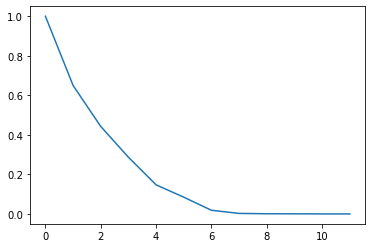

In [10]:
plt.plot(overall_prob)
#plt.plot([10**-i for i in range(51)])
#plt.yscale('log')
#plt.ylim(1e-51, 1e1)

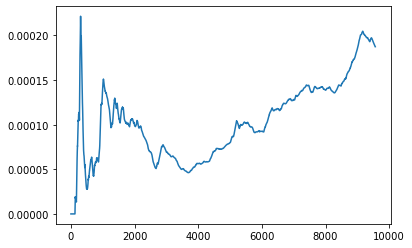

In [11]:
plt.plot(state.result._run_total_prob)
#plt.plot([0, len(state.result._run_total_prob)], [1e-50, 1e-50])

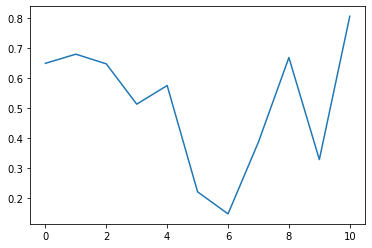

In [14]:
plt.plot([state.result._run_prob[i][-1] for i in range(size-1)])
#plt.plot([0, 49], [0.1, 0.1])